# Π Study
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 9/10/2021|

## Python Imports

In [1]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
from pathlib import Path
import porespy as ps
from scipy import fft, signal

## Run Parameters

In [17]:
runs = ['AB/0.01', 'AB/0.01-1024', 'AB/0.02', 'AB/0.02-sbox', 'AB/0.02-1024',
        'AB/0.02-CFL0.3', 'AB/0.05-128', 'AB/0.05-256', 'AB/0.05', 'AB/0.05-1024',
        'AB/0.10',
        'BA/0.01-128', 'BA/0.01-256', 'BA/0.01',  'BA/0.01-1024', 'BA/0.02',
        'BA/0.05-128', 'BA/0.05-256', 'BA/0.05', 'BA/0.05-1024', 'BA/0.10']
Pis, tau_ss, epsilons, Ls, Ns, Nps, tlims = [], [], [], [], [], [], []


for run in runs:
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    Pi = athinput['problem']['duy0']                    # Π / c_s
    Pis.append(Pi)
    Nx = athinput['mesh']['nx1']                        # Radial x zones
    Ny = athinput['mesh']['nx3']                        # Azimuthal y zones
    Nz = athinput['mesh']['nx2']                        # Vertical z zones
    Ns.append(rf'${Nx:.0f} \times {Ny:.0f} \times {Nz:.0f}$')
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
    Ly = (athinput['mesh']['x3max'] - athinput['mesh']['x3min'])
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
    Ls.append(rf'${Lx:.2f} \times {Ly:.2f} \times {Lz:.2f}')
    Np_tot = athinput['problem']['npx1']\
             *athinput['problem']['npx2']\
             *athinput['problem']['npx3']               # total number of particles
    exp = int(np.log10(Np_tot))
    sig = Np_tot/10**int(exp)
    Nps.append(rf'${sig:.1f}\times10^{exp:d}$')
    Omega = athinput['problem']['omega']                # local Keplerian ang. freq.
    tlims.append(hst['time'][-1])                       # time limit [T]
    epsilons.append(athinput['problem']['epsilon'])     # avg. BG dust/gas ρ-ratio
    tau_ss.append(athinput['particles']['taus0']*Omega) # dimensionless stopping time

df = pd.DataFrame(
    {
        "Run": runs,
        r"$\Pi$": Pis,
        r"$\tau_s$": tau_ss,
        r"$\epsilon$": epsilons,
        r"$L_x \times L_y \times L_z\,[H]$": Ls,
        r"$N_x \times N_y \times N_z$": Ns,
        r"$N_p$": Nps,
        r"$\Delta t\,/\,T$": tlims
    }
)
df.style.format({
    r"$\Pi$": r"${:.2f}$",
    r"$\tau_s$": r"${:.1f}$",
    r"$\epsilon$": r"${:.1f}$",
    r"$\Delta t\,/\,T$": r"${:.0f}\,$",
})

# AB

## Dust

### Saturation Morphology

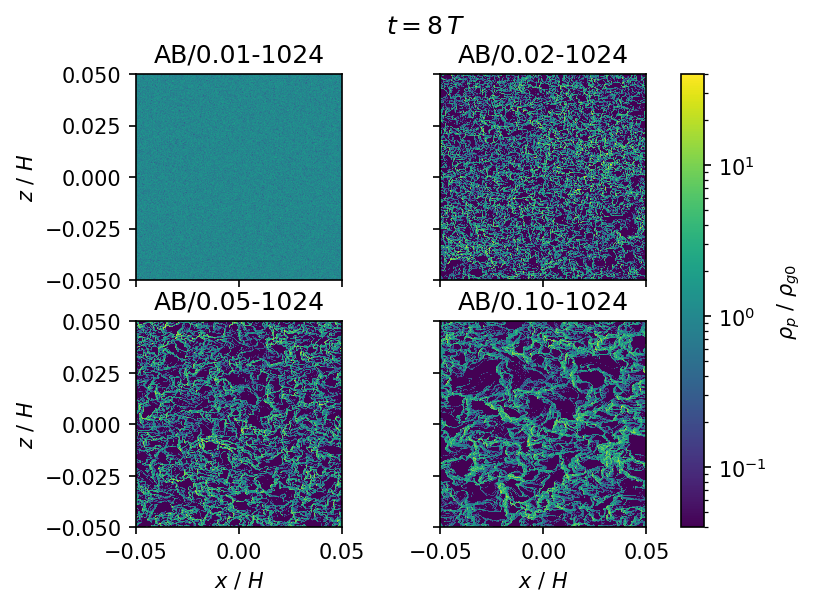

In [16]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['AB/0.01-1024', 'AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']
vmin, vmax = 0.04, 40

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clipped = np.clip(data['rhop'][0], vmin, vmax)

    # Plot
    img = ax.pcolormesh(xf, zf, clipped, norm=colors.LogNorm(vmin, vmax))
    ax.set(title=f'{runs[i]:s}', aspect='equal',
           xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

### Dust 2D FFT

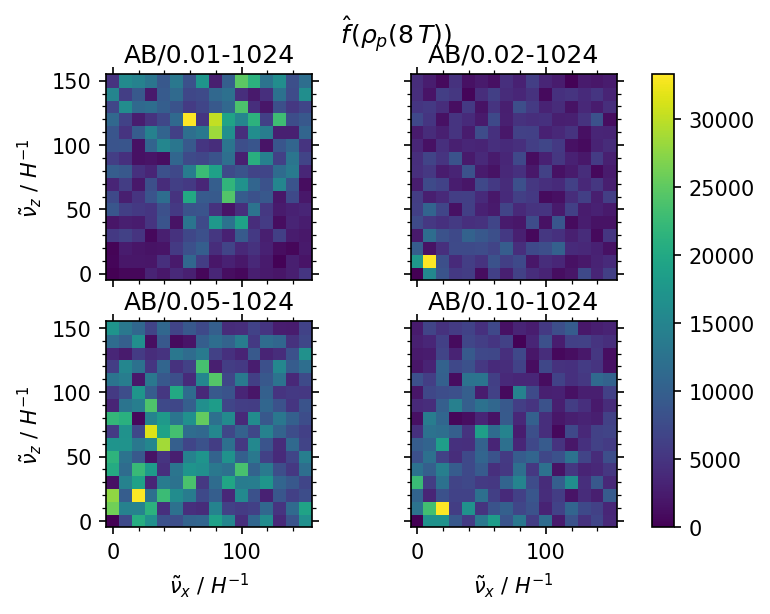

In [6]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['AB/0.01-1024', 'AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']

for i,ax in enumerate(axs.flat):
    # Load snapshot and compute 2D FFT
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
    Nx = athinput['mesh']['nx1']
    Nz = athinput['mesh']['nx2']
    xrate = Nx/Lx # samples per gas scale height, H
    zrate = Nz/Lz
    νx = fft.rfftfreq(Nx, d=(1/xrate)) # sample wavenumbers
    νz = fft.rfftfreq(Nz, d=(1/zrate))
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
        athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    fft2 = fft.rfft2(data['rhop'][0], workers=4)

    # Plot
    fft2[0,0] = 0
    img = ax.pcolormesh(νx[:16], νz[:16], abs(fft2[:16,:16]), shading='auto')
    ax.set(title=f'{runs[i]:s}', aspect='equal',
           xlabel=r'$\tilde{\nu}_x$ / $H^{-1}$',
           ylabel=r'$\tilde{\nu}_z$ / $H^{-1}$')
    ax.label_outer()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True)
fig.suptitle(r'$\^f(\rho_p({:.0f}\,T))$'.format(data['Time']))
cb = fig.colorbar(img, ax=axs[:,:])

## Gas

### Turbulent Mach Number

In [41]:
runs = ['AB/0.01-1024', 'AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']
dirs = [['x', 'dux',   'dux2', 1],
        ['y', 'duy',   'duy2', 1],
        ['z', '2-mom', '2-KE', 2]]
machs = np.zeros((len(runs), len(dirs)))
avgvxs = np.zeros(len(runs))
t_sat = [2, 2, 4, 1] # [T]

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    dt = athinput['output3']['dt']        # time between hst outputs
    i_sat = int(t_sat[i] / dt)            # output index of sat. state
    c_s = athinput['hydro']['iso_sound_speed']
    Np_tot = athinput['problem']['npx1']*athinput['problem']['npx2']\
             *athinput['problem']['npx3'] # total number of particles
    Pi = athinput['problem']['duy0']      # global rad. press. grad.
    ηv_K = Pi*c_s                         # velocity (JY07)
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    mass = hst['mass']
    for j,dir in enumerate(dirs):
        disp = np.sqrt(dir[3]*hst[dir[2]]/mass - (hst[dir[1]]/mass)**2)
        mach = disp/c_s
        machs[i,j] = np.average(mach[i_sat:])
    avgvxs[i] = np.average(hst['vp1'][i_sat:])/ηv_K/Np_tot

df = pd.DataFrame({
    "Run": runs,
    "Ma_x": machs[:,0],
    "Ma_y": machs[:,1],
    "Ma_z": machs[:,2],
    "⟨𝑣ₓ⟩": avgvxs})
df.style.format({
    "Ma_x": "{:.1e}",
    "Ma_y": "{:.1e}",
    "Ma_z": "{:.1e}",
    "⟨𝑣ₓ⟩":"{:.3f}"})

### Gas Morphology

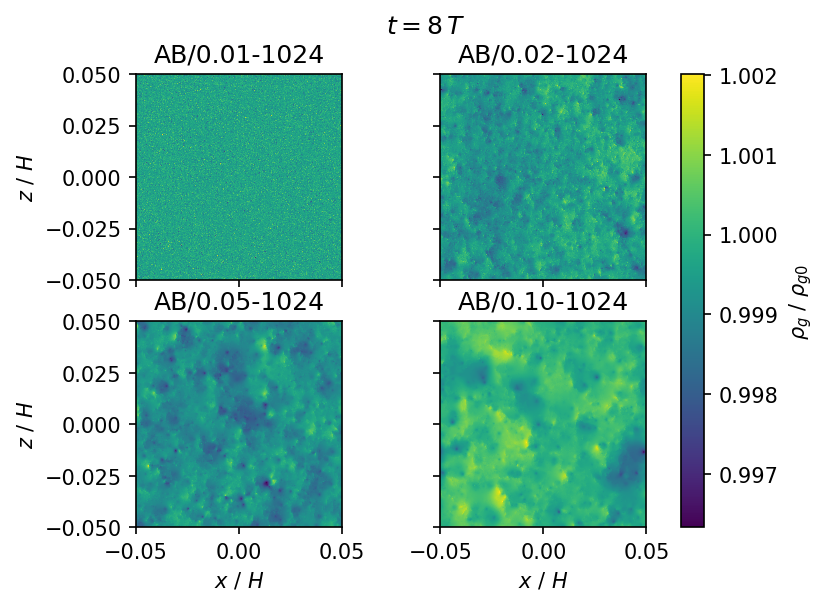

In [7]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['AB/0.01-1024', 'AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out1.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    
    # Plot
    img = ax.pcolormesh(xf, zf, data['rho'][0])
    ax.set(title=f'{runs[i]:s}', aspect='equal',
           xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_g$ / $\rho_{g0}$')

### Gas 2D FFT

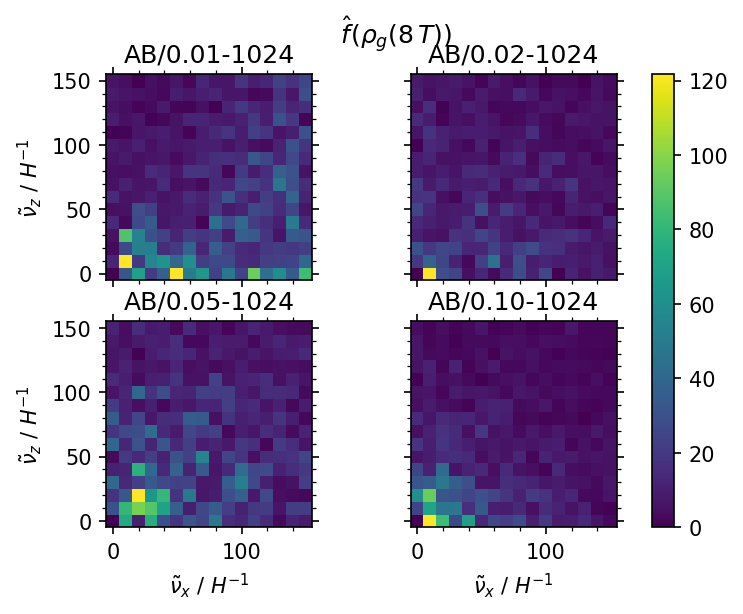

In [8]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['AB/0.01-1024', 'AB/0.02-1024', 'AB/0.05-1024', 'AB/0.10-1024']

for i,ax in enumerate(axs.flat):
    # Load snapshot and compute 2D FFT
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
    Nx = athinput['mesh']['nx1']
    Nz = athinput['mesh']['nx2']
    xrate = Nx/Lx # samples per gas scale height, H
    zrate = Nz/Lz
    νx = fft.rfftfreq(Nx, d=(1/xrate)) # sample wavenumbers
    νz = fft.rfftfreq(Nz, d=(1/zrate))
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                athinput["job"]["problem_id"]+'.out1.*.athdf')))
    data = athena_read.athdf(outputs[0])
    fft2 = fft.rfft2(data['rho'][0], workers=4)

    # Plot
    fft2[0,0] = 0
    img = ax.pcolormesh(νx[:16], νz[:16], abs(fft2[:16,:16]), shading='auto')
    ax.set(title=f'{runs[i]:s}', aspect='equal',
           xlabel=r'$\tilde{\nu}_x$ / $H^{-1}$',
           ylabel=r'$\tilde{\nu}_z$ / $H^{-1}$')
    ax.label_outer()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True)
fig.suptitle(r'$\^f(\rho_g({:.0f}\,T))$'.format(data['Time']))
cb = fig.colorbar(img, ax=axs[:,:])

## AB, Π=0.01

### Dust Density Dispersion

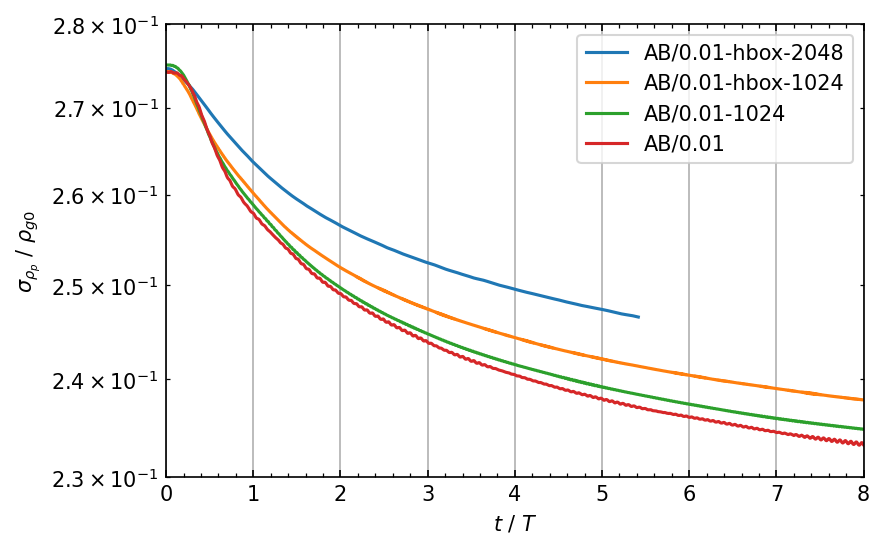

In [6]:
fig, ax = plt.subplots(dpi=150)
runs = ['AB/0.01-hbox-2048', 'AB/0.01-hbox-1024', 'AB/0.01-1024', 'AB/0.01']

for run in runs:
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
    ax.semilogy(times, rhop_amps, label=run)

ax.set(xlabel=r'$t$ / $T$', ylabel=r'$\sigma_{\rho_p}$ / $\rho_{g0}$',
       xlim=(0, 8), ylim=(0.23, 0.28))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

## AB, Π=0.02

### Dust Density Dispersion

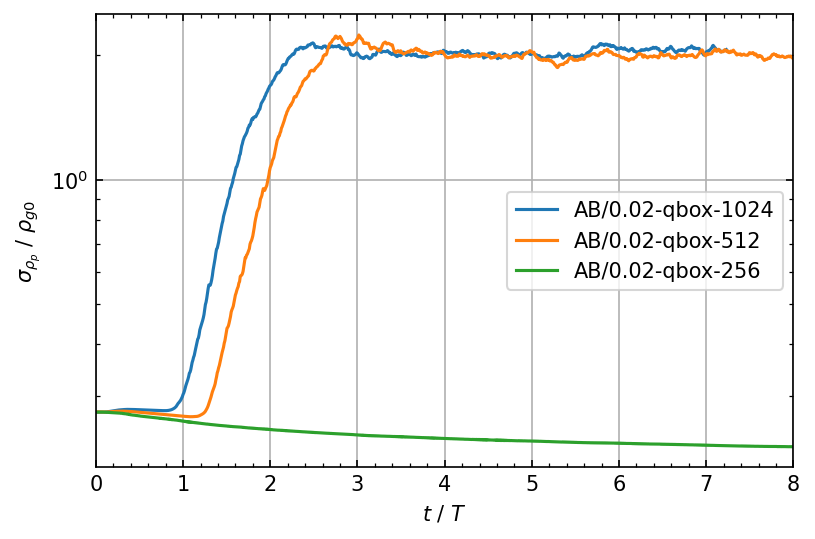

In [3]:
fig, ax = plt.subplots(dpi=150)
runs = ['AB/0.02-qbox-1024', 'AB/0.02-qbox-512', 'AB/0.02-qbox-256']

for run in runs:
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
    ax.semilogy(times, rhop_amps, label=run)

ax.set(xlabel=r'$t$ / $T$', ylabel=r'$\sigma_{\rho_p}$ / $\rho_{g0}$',
       xlim=(0,8))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

### CPDD

AB/0.02-qbox-512: 30.7% ρₚ = 0


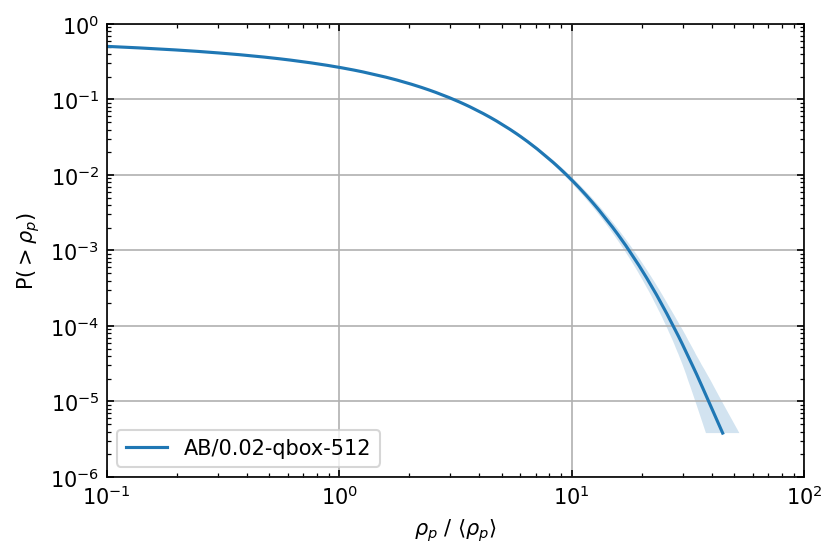

In [26]:
fig, ax = plt.subplots(dpi=150)
runs = [
       # 'AB/0.02-qbox-1024',
       'AB/0.02-qbox-512',
       # 'AB/0.02-qbox-256'
       ]

for run in runs:
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    data = np.load('../nonlinear/Pi/%s/output/cpdd.npz'%run)
    nonzeros = np.count_nonzero(data['avgs'])
    size = data['avgs'].size
    zeros = size - nonzeros
    print('{:<14s}: {:.1f}% ρₚ = 0'.format(run, 100*zeros/size))
    ax.loglog(data['avgs'], data['cdf'], label=run)
    ax.fill_betweenx(data['cdf'], data['avgs']/data['stds'],
                     data['avgs']*data['stds'], alpha=0.2)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.set(xlim=(0.1, 1e2), ylim=(1e-6, 1),
       xlabel=r'$\rho_p$ / $\langle \rho_p \rangle$',
       ylabel=r'P$(>\rho_p)$')
ax.legend(ncol=1, loc='lower left')
ax.grid()

### Saturation Morphology

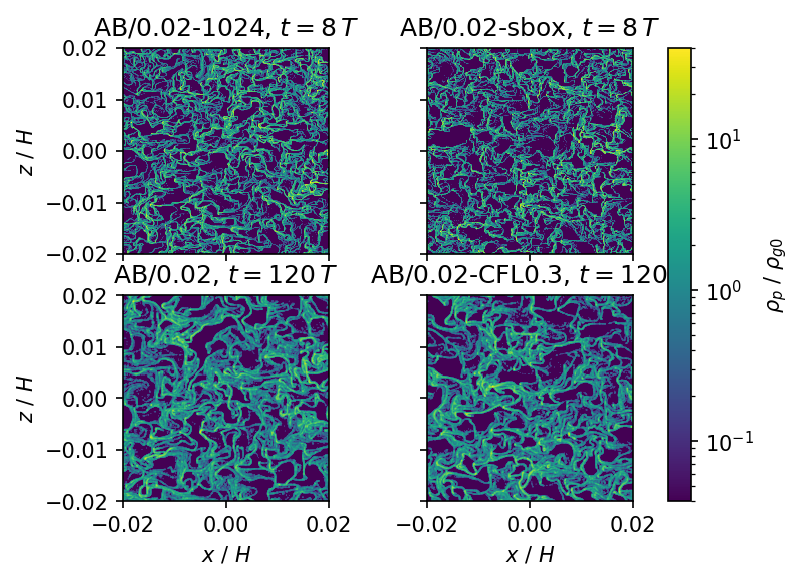

In [26]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['AB/0.02-1024', 'AB/0.02-sbox', 'AB/0.02', 'AB/0.02-CFL0.3']
vmin, vmax = 0.04, 40

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clipped = np.clip(data['rhop'][0], vmin, vmax)

    # Plot
    img = ax.pcolormesh(xf, zf, clipped, norm=colors.LogNorm(vmin, vmax))
    ax.set(title=r'{:s}, $t = {:.0f}\,T$'.format(runs[i], data['Time']/T),
           aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
           xlim=(-0.02, 0.02), ylim=(-0.02, 0.02))
    ax.label_outer()
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

## AB, Π=0.05

### Dust Density Dispersion

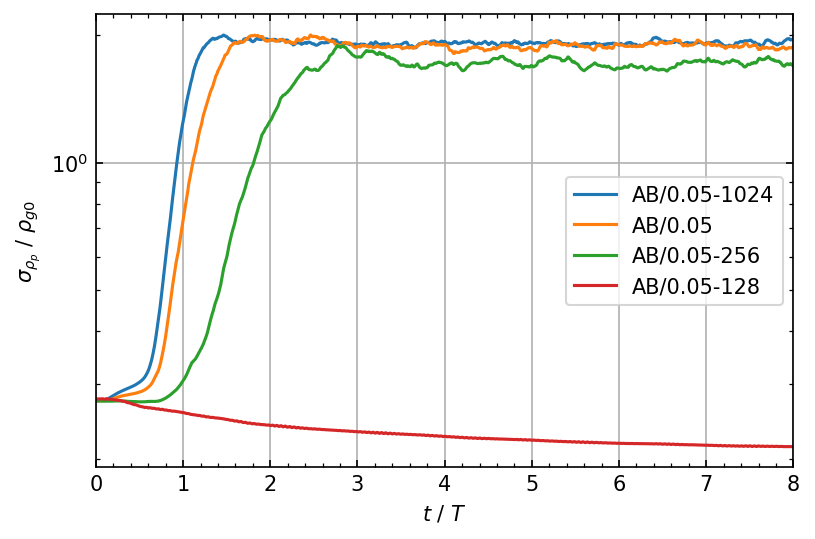

In [11]:
fig, ax = plt.subplots(dpi=150)
runs = ['AB/0.05-1024', 'AB/0.05', 'AB/0.05-256', 'AB/0.05-128']

for run in runs:
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
    ax.semilogy(times, rhop_amps, label=run)

ax.set(xlabel=r'$t$ / $T$', ylabel=r'$\sigma_{\rho_p}$ / $\rho_{g0}$',
       xlim=(0, 8))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

### CPDD

AB/0.05-1024: 30.3% ρₚ = 0
AB/0.05     : 27.1% ρₚ = 0
AB/0.05-256 : 19.5% ρₚ = 0


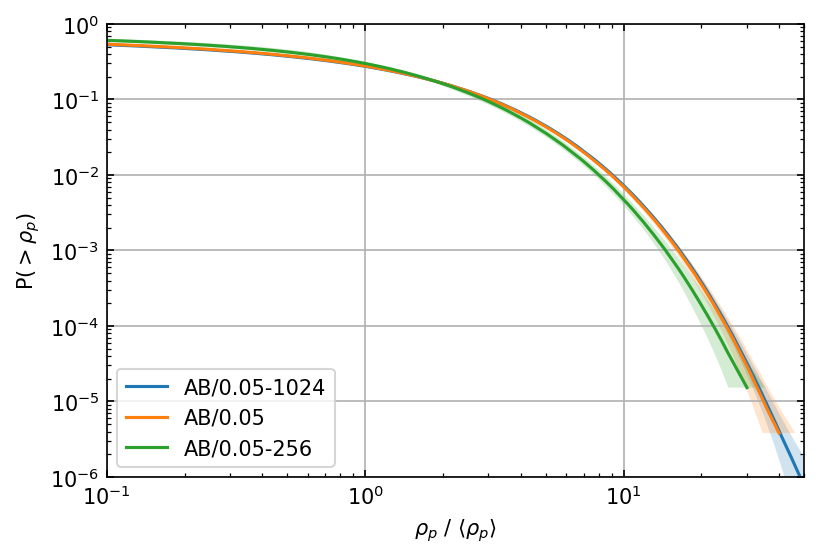

In [12]:
fig, ax = plt.subplots(dpi=150)
runs = ['AB/0.05-1024', 'AB/0.05', 'AB/0.05-256']

for run in runs:
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    data = np.load('../nonlinear/Pi/%s/output/cpdd.npz'%run)
    nonzeros = np.count_nonzero(data['avgs'])
    size = data['avgs'].size
    zeros = size - nonzeros
    print('{:<12s}: {:.1f}% ρₚ = 0'.format(run, 100*zeros/size))
    ax.loglog(data['avgs'], data['cdf'], label=run)
    ax.fill_betweenx(data['cdf'], data['avgs']/data['stds'],
                     data['avgs']*data['stds'], alpha=0.2)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.set(xlim=(0.1, 50), ylim=(1e-6, 1),
       xlabel=r'$\rho_p$ / $\langle \rho_p \rangle$',
       ylabel=r'P$(>\rho_p)$')
ax.legend(ncol=1, loc='lower left')
ax.grid()

### Saturation Morphology

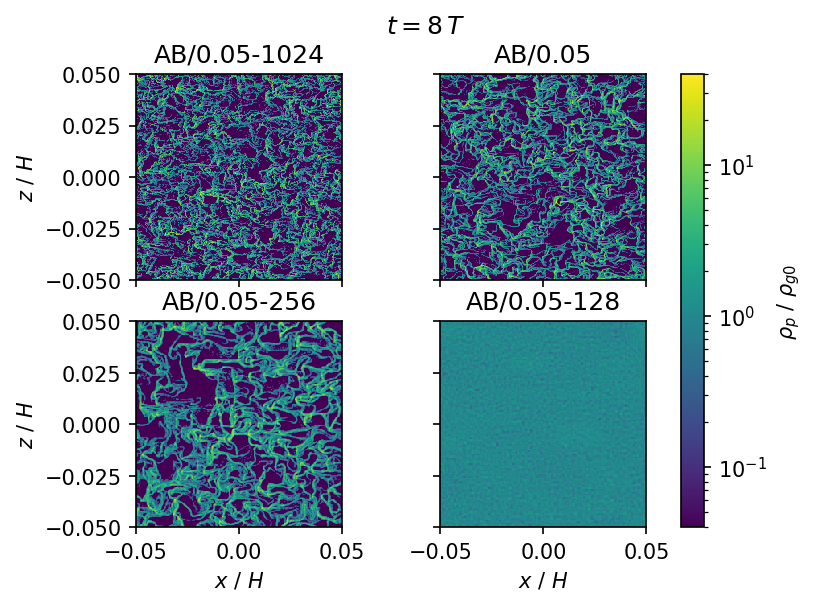

In [29]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['AB/0.05-1024', 'AB/0.05', 'AB/0.05-256', 'AB/0.05-128']
vmin, vmax = 0.04, 40

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clipped = np.clip(data['rhop'][0], vmin, vmax)

    # Plot
    img = ax.pcolormesh(xf, zf, clipped, norm=colors.LogNorm(vmin, vmax))
    ax.set(title=f'{runs[i]:s}', aspect='equal',
           xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

## AB, Π=0.10

### Dust Density Dispersion

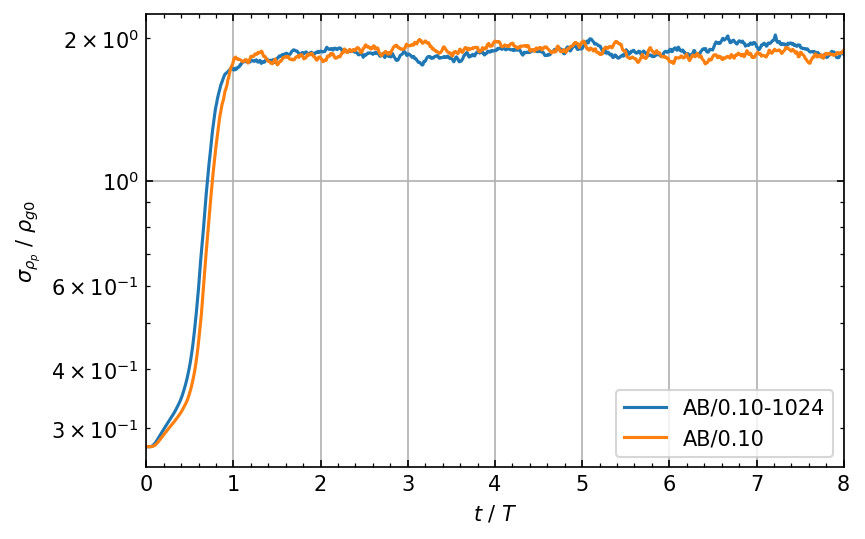

In [13]:
fig, ax = plt.subplots(dpi=150)
runs = ['AB/0.10-1024', 'AB/0.10']

for run in runs:
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
    ax.semilogy(times, rhop_amps, label=run)

ax.set(xlabel=r'$t$ / $T$', ylabel=r'$\sigma_{\rho_p}$ / $\rho_{g0}$',
       xlim=(0, 8))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

### CPDD

AB/0.10-1024: 27.7% ρₚ = 0
AB/0.10     : 27.6% ρₚ = 0


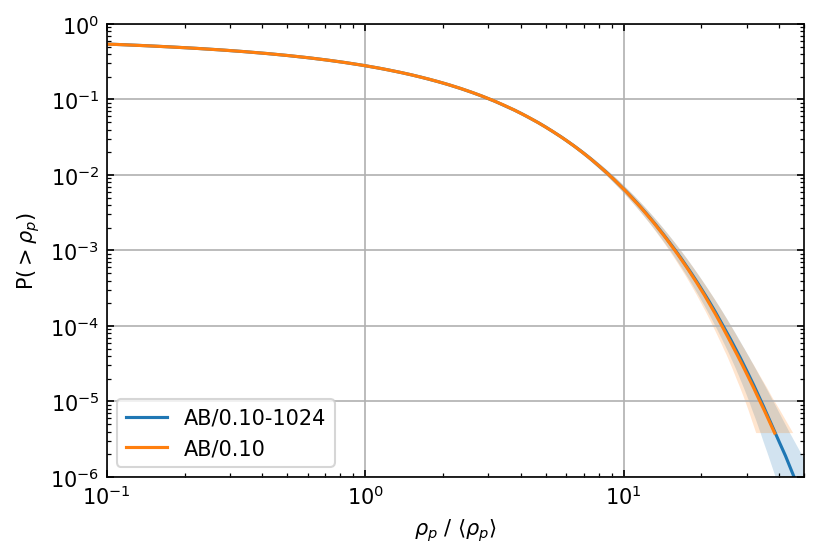

In [14]:
fig, ax = plt.subplots(dpi=150)
runs = ['AB/0.10-1024', 'AB/0.10']

for run in runs:
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    data = np.load('../nonlinear/Pi/%s/output/cpdd.npz'%run)
    nonzeros = np.count_nonzero(data['avgs'])
    size = data['avgs'].size
    zeros = size - nonzeros
    print('{:<12s}: {:.1f}% ρₚ = 0'.format(run, 100*zeros/size))
    ax.loglog(data['avgs'], data['cdf'], label=run)
    ax.fill_betweenx(data['cdf'], data['avgs']/data['stds'],
                     data['avgs']*data['stds'], alpha=0.2)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.set(xlim=(0.1, 50), ylim=(1e-6, 1),
       xlabel=r'$\rho_p$ / $\langle \rho_p \rangle$',
       ylabel=r'P$(>\rho_p)$')
ax.legend(ncol=1, loc='lower left')
ax.grid()

### Saturation Morphology

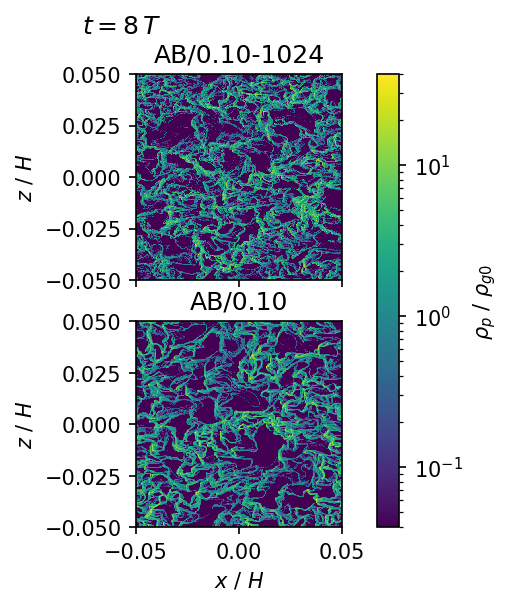

In [13]:
fig, axs = plt.subplots(2, 1, dpi=150)
runs = ['AB/0.10-1024', 'AB/0.10']
vmin, vmax = 0.04, 40

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clipped = np.clip(data['rhop'][0], vmin, vmax)

    # Plot
    img = ax.pcolormesh(xf, zf, clipped, norm=colors.LogNorm(vmin, vmax))
    ax.set(title=f'{runs[i]:s}', aspect='equal',
           xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

# BA

## Dust

### Saturation Morphology

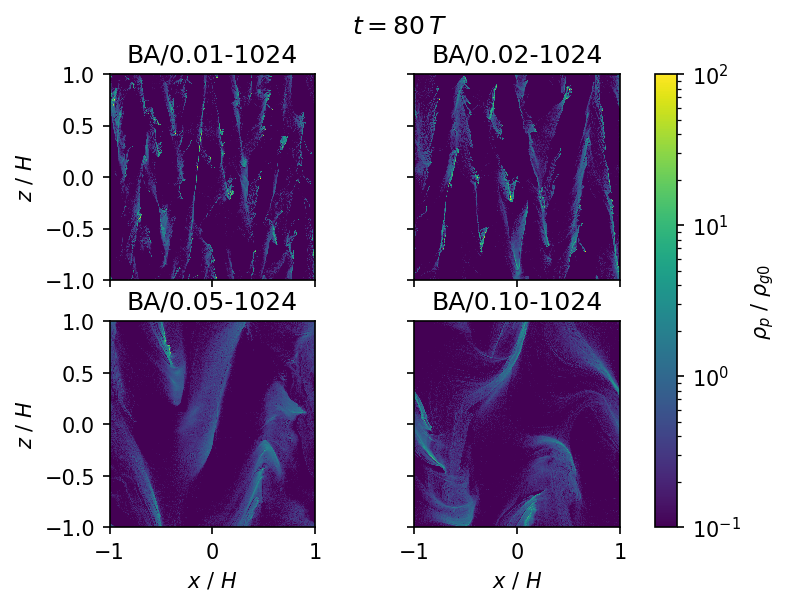

In [16]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
vmin, vmax = 0.1, 100

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clipped = np.clip(data['rhop'][0], vmin, vmax)
    
    # Plot
    img = ax.pcolormesh(xf, zf, clipped, norm=colors.LogNorm(vmin, vmax))
    ax.set(title=r'{:s}'.format(runs[i]), aspect='equal',
           xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

### Dust 2D FFT

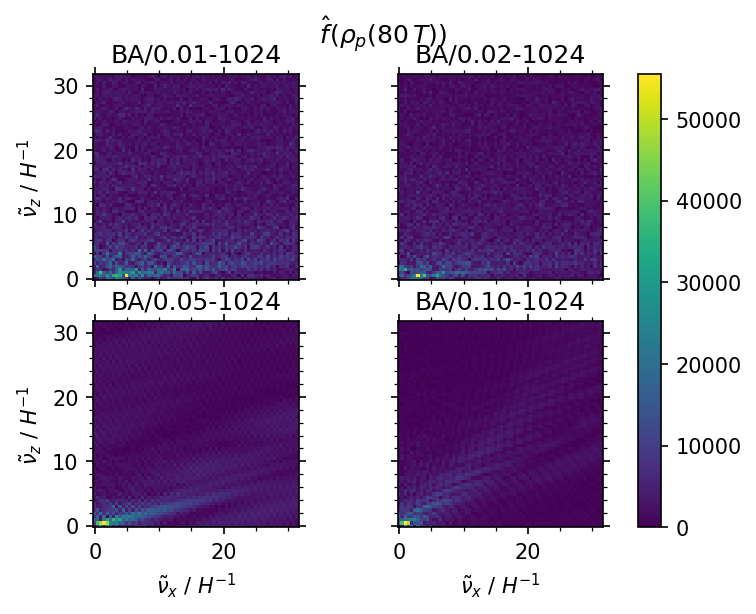

In [25]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']

for i,ax in enumerate(axs.flat):
    # Load snapshot and compute 2D FFT
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
    Nx = athinput['mesh']['nx1']
    Nz = athinput['mesh']['nx2']
    νx = fft.rfftfreq(Nx, d=(Lx/Nx)) # sample wavenumbers
    νz = fft.rfftfreq(Nz, d=(Lz/Nz))
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    fft2 = fft.rfft2(data['rhop'][0], workers=4)
    
    # Plot
    fft2[0,0] = 0 # zero out average amplitude
    img = ax.pcolormesh(νx[:64], νz[:64], abs(fft2[:64,:64]), shading='auto')
    ax.set(title='{:s}'.format(runs[i]), aspect='equal',
           xlabel=r'$\tilde{\nu}_x$ / $H^{-1}$',
           ylabel=r'$\tilde{\nu}_z$ / $H^{-1}$')
    ax.label_outer()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True)
fig.suptitle(r'$\^f(\rho_p({:.0f}\,T))$'.format(data['Time']))
cb = fig.colorbar(img, ax=axs[:,:])

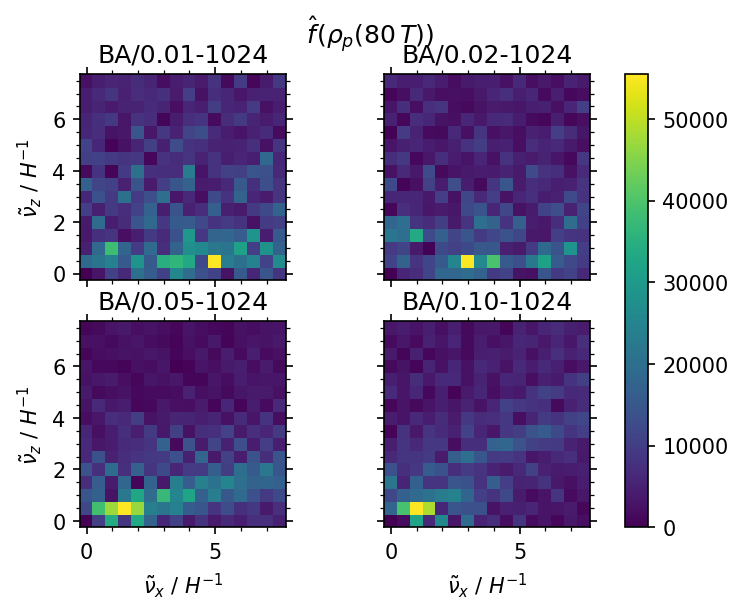

In [27]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']

for i,ax in enumerate(axs.flat):
    # Load snapshot and compute 2D FFT
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
    Nx = athinput['mesh']['nx1']
    Nz = athinput['mesh']['nx2']
    νx = fft.rfftfreq(Nx, d=(Lx/Nx)) # sample wavenumbers
    νz = fft.rfftfreq(Nz, d=(Lz/Nz))
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    fft2 = fft.rfft2(data['rhop'][0], workers=4)
    
    # Plot
    fft2[0,0] = 0 # zero out average amplitude
    img = ax.pcolormesh(νx[:16], νz[:16], abs(fft2[:16,:16]), shading='auto')
    ax.set(title='{:s}'.format(runs[i]), aspect='equal',
           xlabel=r'$\tilde{\nu}_x$ / $H^{-1}$',
           ylabel=r'$\tilde{\nu}_z$ / $H^{-1}$')
    ax.label_outer()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True)
fig.suptitle(r'$\^f(\rho_p({:.0f}\,T))$'.format(data['Time']))
cb = fig.colorbar(img, ax=axs[:,:])

### Dust Autocorrelation (`scipy`)

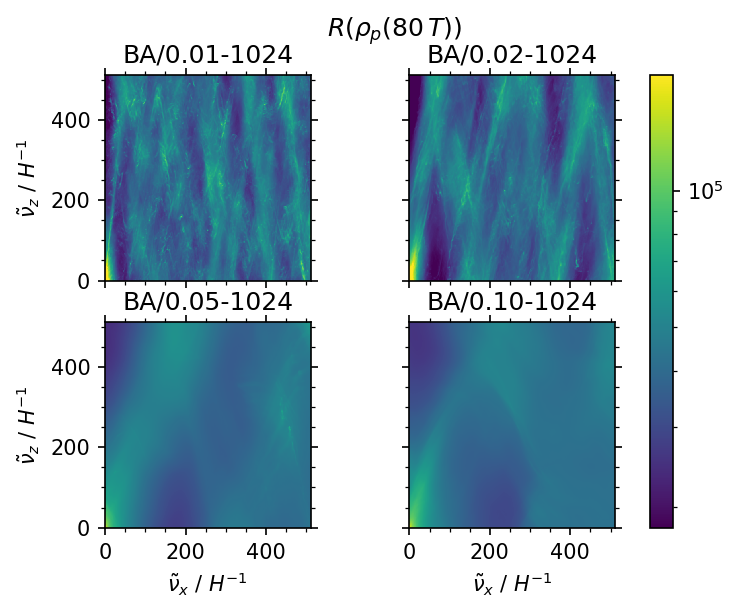

In [2]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
# vmin, vmax = 7.5, 750
vmin, vmax = 1.8e4, 1.8e5

for i,ax in enumerate(axs.flat):
    # Load snapshot and compute 2-pt correlation function
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
    Nx = athinput['mesh']['nx1']
    Nz = athinput['mesh']['nx2']
    νx = np.arange(1024)
    νz = np.arange(1024)
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    # dataFT = fft.fft(data['rhop'][0], axis=1, workers=4)
    # dataAC = fft.ifft(dataFT*np.conjugate(dataFT), axis=1, workers=4).real
    dataFT = fft.fft2(data['rhop'][0], workers=4)
    dataAC = fft.ifft2(dataFT*np.conjugate(dataFT), workers=4).real
    clipped = np.clip(dataAC, vmin, vmax)
    
    # Plot
    # fft2[0,0] = 0 # zero out average amplitude
    img = ax.pcolormesh(νx[:512]/512, νz[:512]/512, clipped[:512,:512], norm=colors.LogNorm(vmin, vmax),
                        shading='auto')
    ax.set(title='{:s}'.format(runs[i]), aspect='equal',
           xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True)
fig.suptitle(r'$R(\rho_p({:.0f}\,T))$'.format(data['Time']))
cb = fig.colorbar(img, ax=axs[:,:])

## Gas

### Turbulent Mach Number

In [42]:
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']
dirs = [['x', 'dux',   'dux2', 1],
        ['y', 'duy',   'duy2', 1],
        ['z', '2-mom', '2-KE', 2]]
machs = np.zeros((len(runs), len(dirs)))
avgvxs = np.zeros(len(runs))
t_sat = [2, 2, 4, 1] # [T]

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    dt = athinput['output3']['dt']        # time between hst outputs
    i_sat = int(t_sat[i] / dt)            # output index of sat. state
    c_s = athinput['hydro']['iso_sound_speed']
    Np_tot = athinput['problem']['npx1']*athinput['problem']['npx2']\
             *athinput['problem']['npx3'] # total number of particles
    Pi = athinput['problem']['duy0']      # global rad. press. grad.
    ηv_K = Pi*c_s                         # velocity (JY07)
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    mass = hst['mass']
    for j,dir in enumerate(dirs):
        disp = np.sqrt(dir[3]*hst[dir[2]]/mass - (hst[dir[1]]/mass)**2)
        mach = disp/c_s
        machs[i,j] = np.average(mach[i_sat:])
    avgvxs[i] = np.average(hst['vp1'][i_sat:])/ηv_K/Np_tot

df = pd.DataFrame({
    "Run": runs,
    "Ma_x": machs[:,0],
    "Ma_y": machs[:,1],
    "Ma_z": machs[:,2],
    "⟨𝑣ₓ⟩": avgvxs})
df.style.format({
    "Ma_x": "{:.1e}",
    "Ma_y": "{:.1e}",
    "Ma_z": "{:.1e}",
    "⟨𝑣ₓ⟩":"{:.3f}"})

### Gas Saturation

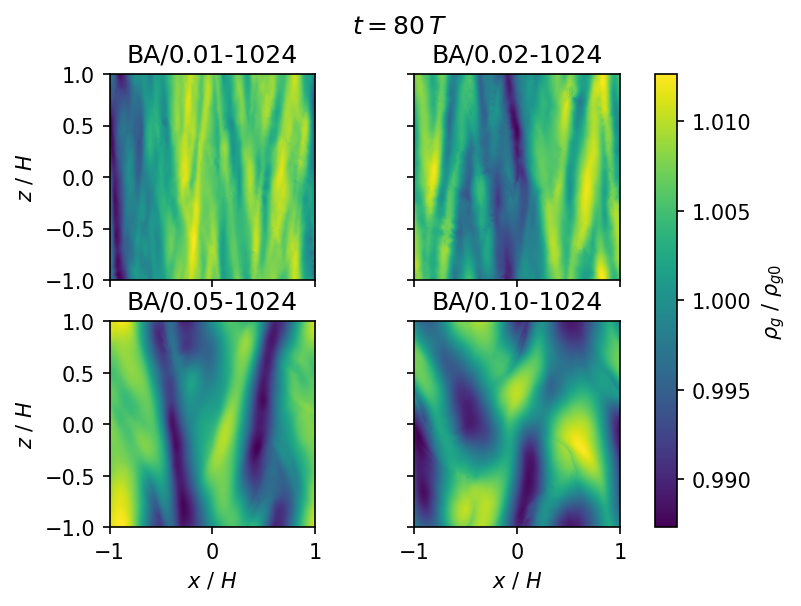

In [32]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out1.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    
    # Plot
    img = ax.pcolormesh(xf, zf, data['rho'][0])
    ax.set(title=r'{:s}'.format(runs[i]), aspect='equal',
           xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_g$ / $\rho_{g0}$')

### Gas 2D FFT

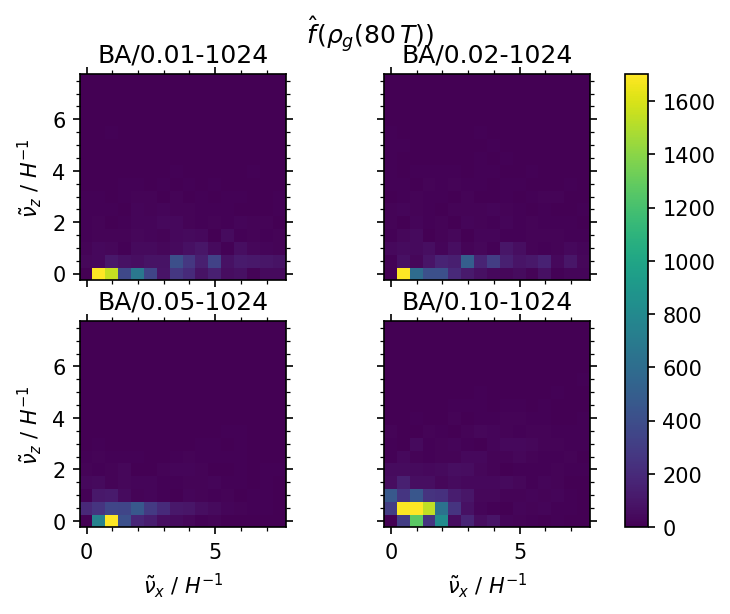

In [33]:
fig, axs = plt.subplots(2, 2, dpi=150)
runs = ['BA/0.01-1024', 'BA/0.02-1024', 'BA/0.05-1024', 'BA/0.10-1024']

for i,ax in enumerate(axs.flat):
    # Load snapshot and compute 2D FFT
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])
    Nx = athinput['mesh']['nx1']
    Nz = athinput['mesh']['nx2']
    xrate = Nx/Lx # samples per gas scale height, H
    zrate = Nz/Lz
    νx = fft.rfftfreq(Nx, d=(1/xrate)) # sample wavenumbers
    νz = fft.rfftfreq(Nz, d=(1/zrate))
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out1.*.athdf')))
    data = athena_read.athdf(outputs[0])
    fft2 = fft.rfft2(data['rho'][0], workers=4)
    
    # Plot
    fft2[0,0] = 0
    img = ax.pcolormesh(νx[:16], νz[:16], abs(fft2[:16,:16]), shading='auto')
    ax.set(title='{:s}'.format(runs[i]), aspect='equal',
           xlabel=r'$\tilde{\nu}_x$ / $H^{-1}$',
           ylabel=r'$\tilde{\nu}_z$ / $H^{-1}$')
    ax.label_outer()
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', top=True, right=True)
fig.suptitle(r'$\^f(\rho_g({:.0f}\,T))$'.format(data['Time']))
cb = fig.colorbar(img, ax=axs[:,:])

## ΒΑ, Π=0.01

### Dust Density Dispersion

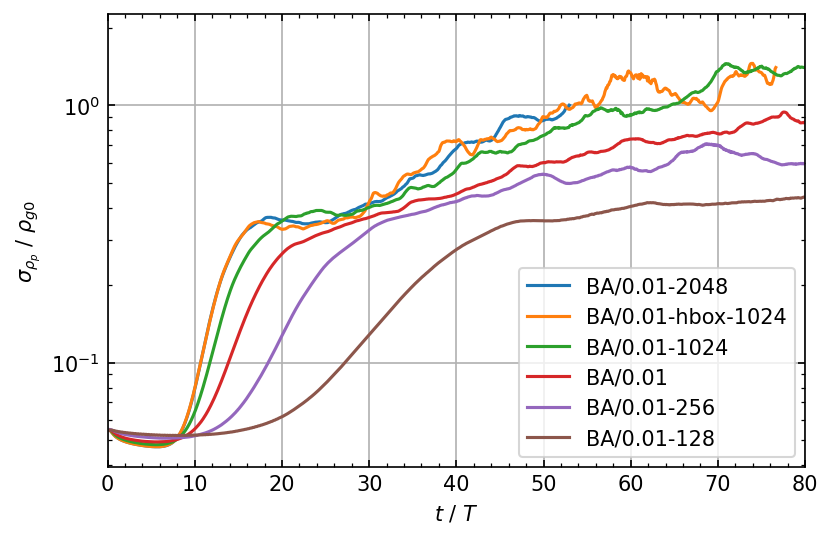

In [17]:
fig, ax = plt.subplots(dpi=150)
runs = ['BA/0.01-2048', 'BA/0.01-hbox-1024', 'BA/0.01-1024',
        'BA/0.01', 'BA/0.01-256', 'BA/0.01-128']

for run in runs:
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
    ax.semilogy(times, rhop_amps, label=run)

ax.set(xlabel=r'$t$ / $T$', ylabel=r'$\sigma_{\rho_p}$ / $\rho_{g0}$',
       xlim=(0, 80))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

**NOTE**: `BA/0.01-hbox-1024` run has crashed twice around $77\,T$ (see std/errout).

### CPDD

BA/0.01-2048     : 1.4% ρₚ = 0
BA/0.01-hbox-1024: 9.4% ρₚ = 0
BA/0.01-1024     : 6.8% ρₚ = 0
BA/0.01          : 9.0% ρₚ = 0
BA/0.01-256      : 8.5% ρₚ = 0
BA/0.01-128      : 3.8% ρₚ = 0


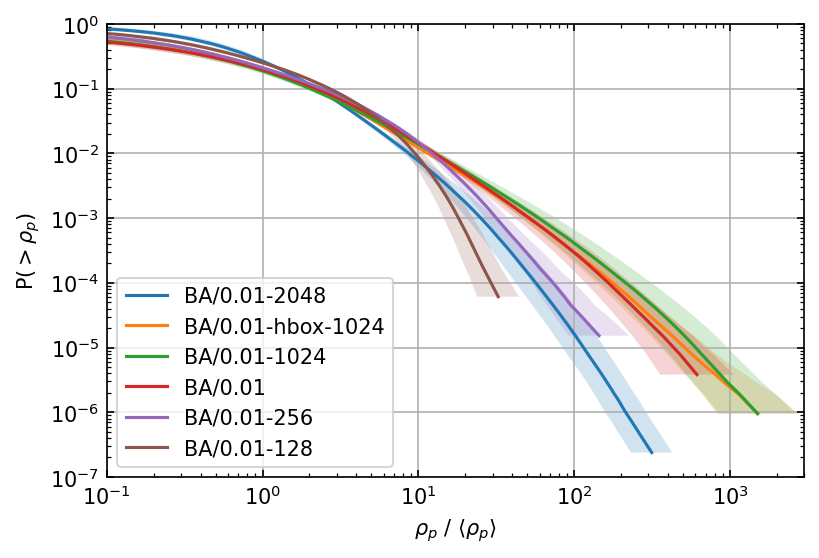

In [18]:
fig, ax = plt.subplots(dpi=150)
runs = ['BA/0.01-2048', 'BA/0.01-hbox-1024', 'BA/0.01-1024', 
        'BA/0.01', 'BA/0.01-256', 'BA/0.01-128']

for run in runs:
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    data = np.load('../nonlinear/Pi/%s/output/cpdd.npz'%run)
    nonzeros = np.count_nonzero(data['avgs'])
    size = data['avgs'].size
    zeros = size - nonzeros
    print('{:<17s}: {:.1f}% ρₚ = 0'.format(run, 100*zeros/size))
    ax.loglog(data['avgs'], data['cdf'], label=run)
    ax.fill_betweenx(data['cdf'], data['avgs']/data['stds'],
                     data['avgs']*data['stds'], alpha=0.2)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.set(xlim=(0.1, 3e3), ylim=(1e-7, 1),
       xlabel=r'$\rho_p$ / $\langle \rho_p \rangle$',
       ylabel=r'P$(>\rho_p)$')
ax.legend(ncol=1, loc='lower left')
ax.grid()

### Saturation Morphology

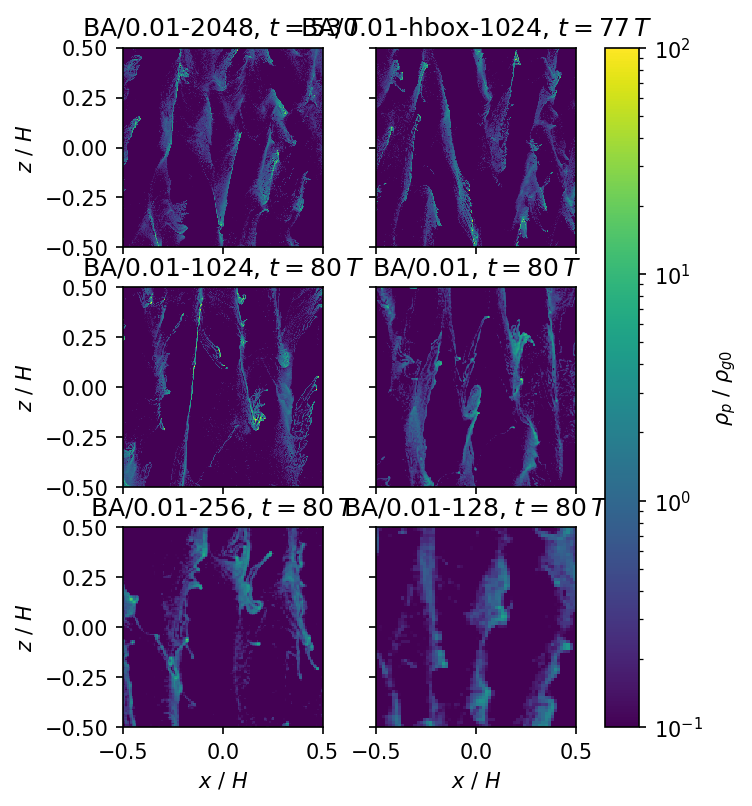

In [65]:
fig, axs = plt.subplots(3, 2, figsize=(5,6), dpi=150)
runs = ['BA/0.01-2048', 'BA/0.01-hbox-1024', 'BA/0.01-1024',
        'BA/0.01', 'BA/0.01-256', 'BA/0.01-128']
vmin, vmax = 0.1, 100

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clipped = np.clip(data['rhop'][0], vmin, vmax)

    # Plot
    img = ax.pcolormesh(xf, zf, clipped, norm=colors.LogNorm(vmin, vmax))
    ax.set(title=r'{:s}, $t = {:.0f}\,T$'.format(runs[i], data['Time']/T),
           aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$',
           xlim=(-0.5, 0.5), ylim=(-0.5, 0.5))
    ax.label_outer()
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

## ΒΑ, Π=0.02

### Dust Density Dispersion

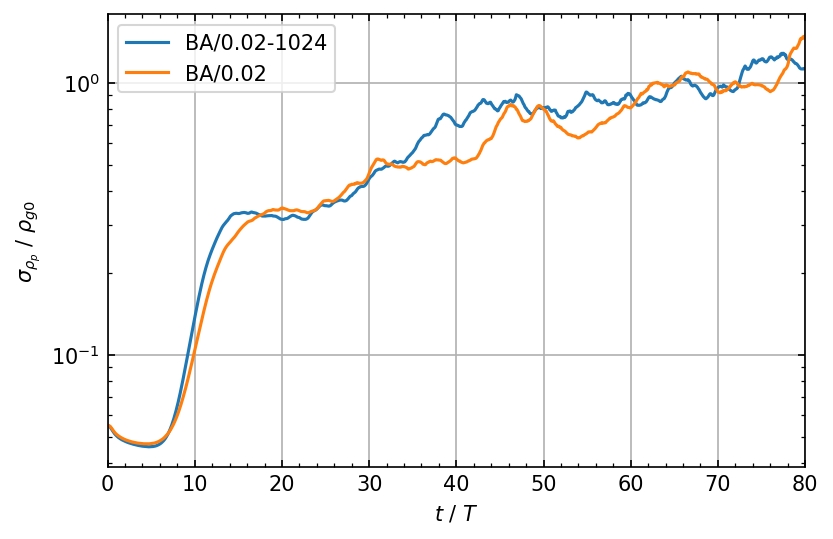

In [19]:
fig, ax = plt.subplots(dpi=150)
runs = ['BA/0.02-1024', 'BA/0.02']

for run in runs:
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
    ax.semilogy(times, rhop_amps, label=run)

ax.set(xlabel=r'$t$ / $T$', ylabel=r'$\sigma_{\rho_p}$ / $\rho_{g0}$',
       xlim=(0, 80))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

### CPDD

BA/0.02-1024  : 1.1% ρₚ = 0
BA/0.02       : 1.8% ρₚ = 0


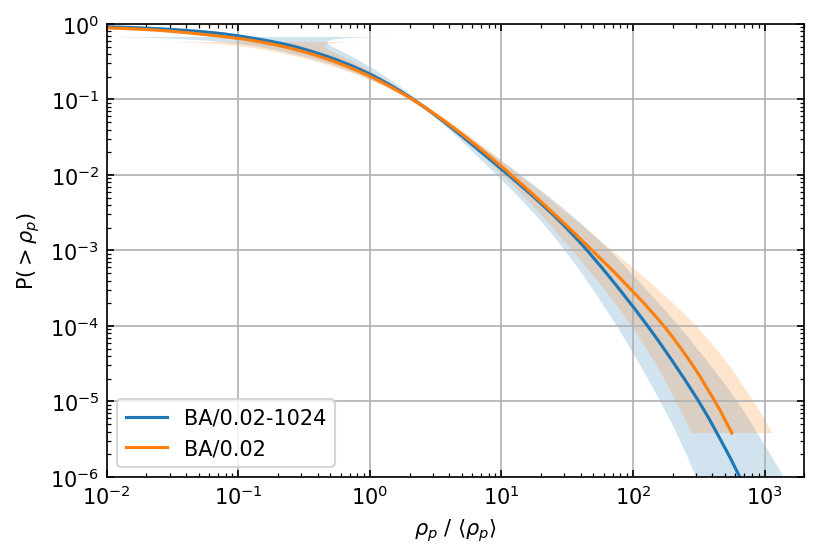

In [20]:
fig, ax = plt.subplots(dpi=150)
runs = ['BA/0.02-1024', 'BA/0.02']

for run in runs:
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    data = np.load('../nonlinear/Pi/%s/output/cpdd.npz'%run)
    nonzeros = np.count_nonzero(data['avgs'])
    size = data['avgs'].size
    zeros = size - nonzeros
    print('{:<14s}: {:.1f}% ρₚ = 0'.format(run, 100*zeros/size))
    ax.loglog(data['avgs'], data['cdf'], label=run)
    ax.fill_betweenx(data['cdf'], data['avgs']/data['stds'],
                     data['avgs']*data['stds'], alpha=0.2)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.set(xlim=(1e-2, 2e3), ylim=(1e-6, 1),
       xlabel=r'$\rho_p$ / $\langle \rho_p \rangle$',
       ylabel=r'P$(>\rho_p)$')
ax.legend(ncol=1, loc='lower left')
ax.grid()

### Saturation Morphology

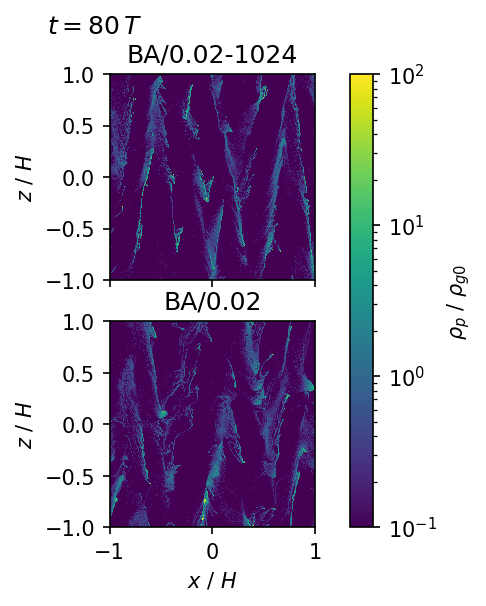

In [45]:
fig, axs = plt.subplots(2, 1, dpi=150)
runs = ['BA/0.02-1024', 'BA/0.02']
vmin, vmax = 0.1, 100

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clipped = np.clip(data['rhop'][0], vmin, vmax)

    # Plot
    img = ax.pcolormesh(xf, zf, clipped, norm=colors.LogNorm(vmin, vmax))
    ax.set(title='{:s}'.format(runs[i]),
           aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

## ΒΑ, Π=0.05

### Dust Density Dispersion

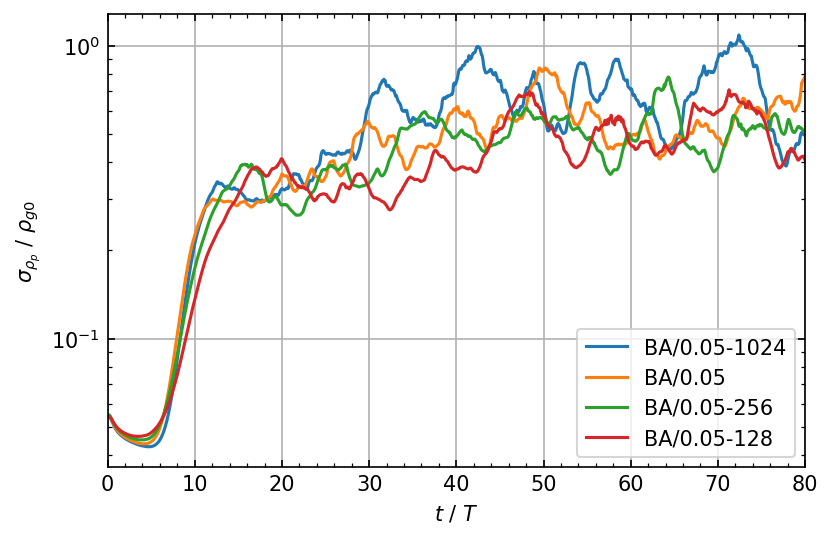

In [22]:
fig, ax = plt.subplots(dpi=150)
runs = ['BA/0.05-1024', 'BA/0.05', 'BA/0.05-256', 'BA/0.05-128']

for run in runs:
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
    ax.semilogy(times, rhop_amps, label=run)

ax.set(xlabel=r'$t$ / $T$', ylabel=r'$\sigma_{\rho_p}$ / $\rho_{g0}$',
       xlim=(0, 80))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

### CPDD

BA/0.05-1024  : 0.9% ρₚ = 0
BA/0.05       : 0.6% ρₚ = 0
BA/0.05-256   : 0.4% ρₚ = 0
BA/0.05-128   : 0.2% ρₚ = 0


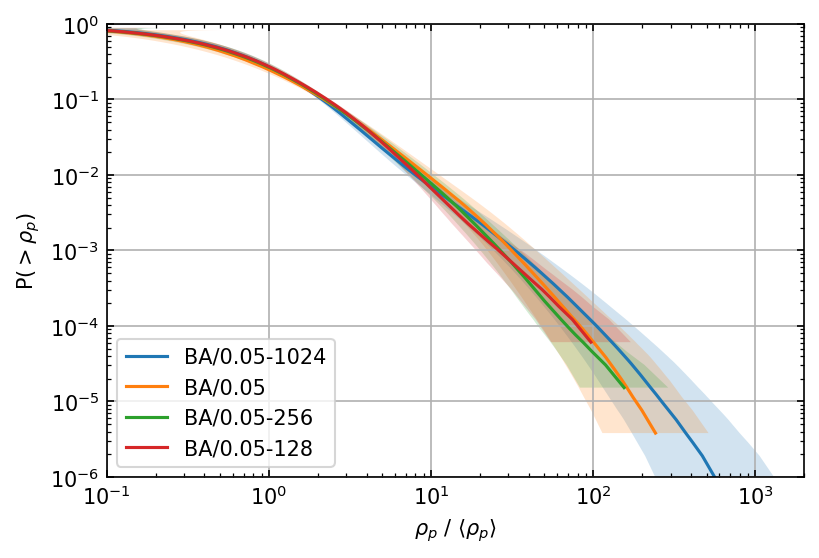

In [23]:
fig, ax = plt.subplots(dpi=150)
runs = ['BA/0.05-1024', 'BA/0.05', 'BA/0.05-256', 'BA/0.05-128']

for run in runs:
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    data = np.load('../nonlinear/Pi/%s/output/cpdd.npz'%run)
    nonzeros = np.count_nonzero(data['avgs'])
    size = data['avgs'].size
    zeros = size - nonzeros
    print('{:<14s}: {:.1f}% ρₚ = 0'.format(run, 100*zeros/size))
    ax.loglog(data['avgs'], data['cdf'], label=run)
    ax.fill_betweenx(data['cdf'], data['avgs']/data['stds'],
                     data['avgs']*data['stds'], alpha=0.2)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.set(xlim=(0.1, 2e3), ylim=(1e-6, 1),
       xlabel=r'$\rho_p$ / $\langle \rho_p \rangle$',
       ylabel=r'P$(>\rho_p)$')
ax.legend(ncol=1, loc='lower left')
ax.grid()

### Saturation Morphology

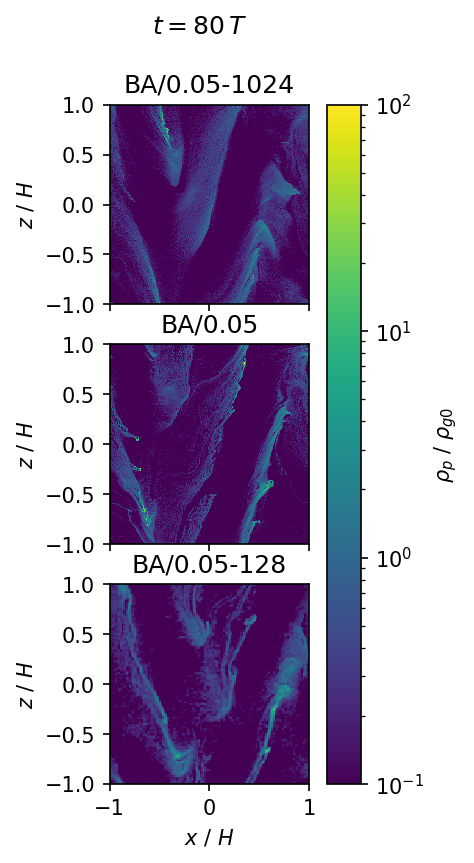

In [66]:
fig, axs = plt.subplots(3, 1, figsize=(3,6), dpi=150)
runs = ['BA/0.05-1024', 'BA/0.05', 'BA/0.05-128']
vmin, vmax = 0.1, 100

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clipped = np.clip(data['rhop'][0], vmin, vmax)

    # Plot
    img = ax.pcolormesh(xf, zf, clipped, norm=colors.LogNorm(vmin, vmax))
    ax.set(title='{:s}'.format(runs[i]),
           aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

## ΒΑ, Π=0.10

### Dust Density Dispersion

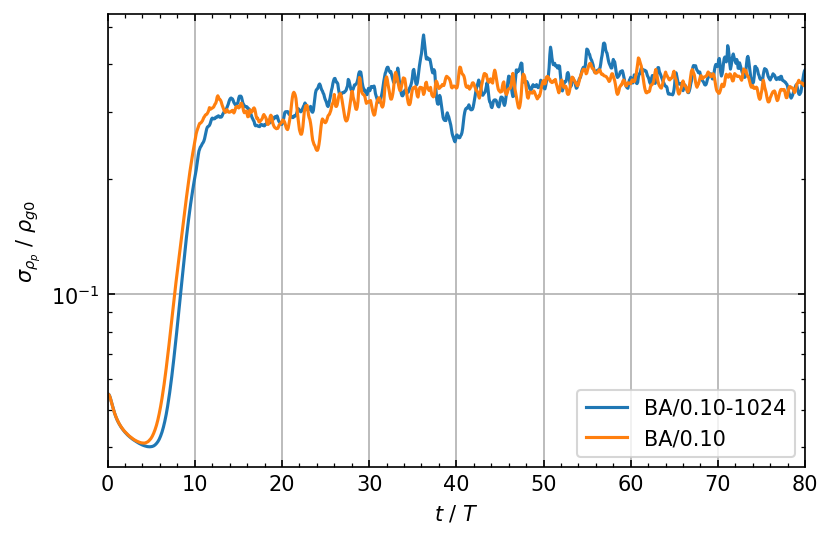

In [24]:
fig, ax = plt.subplots(dpi=150)
runs = ['BA/0.10-1024', 'BA/0.10']

for run in runs:
    hst = athena_read.hst('../nonlinear/Pi/%s/output/SI.hst'%run)
    times = hst['time']
    rhop_amps = np.sqrt(hst['drhop2'] - hst['drhop']**2)
    ax.semilogy(times, rhop_amps, label=run)

ax.set(xlabel=r'$t$ / $T$', ylabel=r'$\sigma_{\rho_p}$ / $\rho_{g0}$',
       xlim=(0, 80))
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.legend()
ax.grid()

### CPDD

BA/0.10-1024  : 0.0% ρₚ = 0
BA/0.10       : 0.0% ρₚ = 0


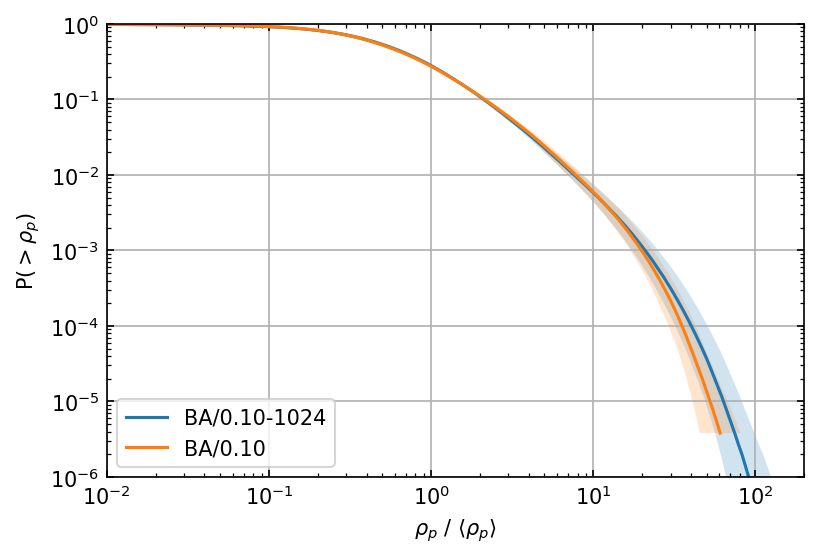

In [25]:
fig, ax = plt.subplots(dpi=150)
runs = ['BA/0.10-1024', 'BA/0.10']

for run in runs:
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%run)
    data = np.load('../nonlinear/Pi/%s/output/cpdd.npz'%run)
    nonzeros = np.count_nonzero(data['avgs'])
    size = data['avgs'].size
    zeros = size - nonzeros
    print('{:<14s}: {:.1f}% ρₚ = 0'.format(run, 100*zeros/size))
    ax.loglog(data['avgs'], data['cdf'], label=run)
    ax.fill_betweenx(data['cdf'], data['avgs']/data['stds'],
                     data['avgs']*data['stds'], alpha=0.2)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.set(xlim=(1e-2, 200), ylim=(1e-6, 1),
       xlabel=r'$\rho_p$ / $\langle \rho_p \rangle$',
       ylabel=r'P$(>\rho_p)$')
ax.legend(ncol=1, loc='lower left')
ax.grid()

### Saturation Morphology

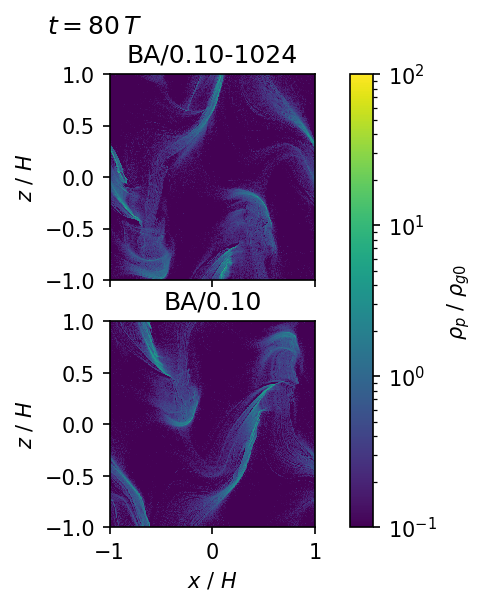

In [51]:
fig, axs = plt.subplots(2, 1, dpi=150)
runs = ['BA/0.10-1024', 'BA/0.10']
vmin, vmax = 0.1, 100

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/Pi/%s/athinput.si'%runs[i])
    c_s = athinput['hydro']['iso_sound_speed'] # sound speed
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    H = c_s/Omega                              # gas scale height
    T = 2*np.pi/Omega                          # orbital period
    outputs = sorted(list(Path('../nonlinear/Pi/%s/athdf/'%runs[i]).glob(
                  athinput["job"]["problem_id"]+'.out2.*.athdf')))
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/H, data['x2f']/H
    clipped = np.clip(data['rhop'][0], vmin, vmax)

    # Plot
    img = ax.pcolormesh(xf, zf, clipped, norm=colors.LogNorm(vmin, vmax))
    ax.set(title='{:s}'.format(runs[i]),
           aspect='equal', xlabel=r'$x$ / $H$', ylabel=r'$z$ / $H$')
    ax.label_outer()
fig.suptitle(r'$t = {:.0f}\,T$'.format(data['Time']/T))
cb = fig.colorbar(img, ax=axs[:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')